# Import data

In [91]:
import pandas as pd

# Read all sheets into a dictionary of DataFrames
# dfs = pd.read_excel('results-12-19.xlsx', sheet_name=None)
# dfs = pd.read_excel('results-12-22.xlsx', sheet_name=None)
# dfs = pd.read_excel('results-12-23.xlsx', sheet_name=None)
dfs = pd.read_excel('results-12-29-decision-sample.xlsx', sheet_name=None)

# Print the names of the sheets
print(dfs.keys())

dict_keys(['support increase', 'support decrease', 'confidence increase', 'confidence decrease', 'supp inc | conf inc', 'supp inc | conf dec', 'supp dec | conf inc', 'supp dec | conf dec', '(old change) supp inc|conf inc', '(old change) supp dec|conf dec', 'vary beta', 'vary |D| size', 'vary K'])


## Add IApriori

In [92]:
dfs_iapriori = pd.read_excel('results-fp-growth-1-5.xlsx', sheet_name=None)
dfs_iapriori.keys()

dict_keys(['support increase', 'support decrease', 'confidence increase', 'confidence decrease', 'supp inc | conf inc', 'supp inc | conf dec', 'supp dec | conf inc', 'supp dec | conf dec', '(old change) supp inc|conf inc', '(old change) supp dec|conf dec', 'vary |D| size', 'vary large |D| size', 'vary n'])

In [93]:
for key, df_iapriori in dfs_iapriori.items():
    if key in dfs:
        # Get the corresponding DataFrame in dfs
        df_main = dfs[key]

        # 1. Update the 'Baseline' column in df_iapriori to 'iapriori'
        df_iapriori['Baseline'] = 'IApriori'
        
        # 2. Rename column 'gen rule time(s)' in df_iapriori to 'Mining time'
        df_iapriori.rename(columns={'gen rule time(s)': 'Mining time'}, inplace=True)
        df_iapriori['Mining time'] = df_iapriori['Mining time'] * 1000  # Convert to ms


        # 3. Fill 'old support' and 'old confidence' in df_iapriori
        #    with the values from dfs[key] where 'Baseline' == 'batch'
        batch_rows = df_main[df_main['Baseline'] == 'batch']
        df_iapriori['old support'] = batch_rows['old support'].values
        df_iapriori['old confidence'] = batch_rows['old confidence'].values

        # Concatenate the updated df_iapriori with the main DataFrame
        dfs[key] = pd.concat([df_main, df_iapriori], ignore_index=True)

## Add DCFinder

In [94]:
dfs_dc = pd.read_excel('results-DCFinder-0109.xlsx', sheet_name=None)
dfs_dc.keys()

dict_keys(['support increase', 'supp inc | conf dec', 'supp dec | conf dec', '(old change) supp dec|conf dec'])

In [95]:
for key, df_dc in dfs_dc.items():
    if key in dfs:
        # Get the corresponding DataFrame in dfs
        df_main = dfs[key]

        # 1. Update the 'Baseline' column in df_iapriori to 'iapriori'
        df_dc['Baseline'] = 'DCFinder'
        
        # 2. Rename column 'gen rule time(s)' to 'Mining time', and scale it by 1000 (in ms)
        df_dc.rename(columns={'Mining time(s)': 'Mining time'}, inplace=True)
        df_dc['Mining time'] = df_dc['Mining time'] * 1000  # Convert to ms

        # 3. Fill 'old support' and 'old confidence' in df_iapriori
        #    with the values from dfs[key] where 'Baseline' == 'batch'
        batch_rows = df_main[df_main['Baseline'] == 'batch']
        df_dc['old support'] = batch_rows['old support'].values
        df_dc['old confidence'] = batch_rows['old confidence'].values

        # Concatenate the updated df_iapriori with the main DataFrame
        dfs[key] = pd.concat([df_main, df_dc], ignore_index=True)

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Set default figure size (width, height in inches)
plt.rcParams['figure.figsize'] = [4, 3]

plt.rcParams['font.size'] = 16

plt.rcParams['lines.markersize'] = 10  # Default marker size is 6

In [97]:
VERBOSE = False

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorMap = {
    "batch": colors[1],
    "IncMiner1.0": colors[0],
    "IncMiner": colors[0],
    "IncMiner0.7": colors[2],
    "IncMinerNS": colors[4],
    "IApriori": colors[3],
    "DCFinder": colors[5]
}

markerMap = {
    "batch": '^',
    "IncMiner1.0": 's',
    "IncMiner": 's',
    "IncMiner0.7": 'v',
    "IncMinerNS": '*',
    "IApriori": '+',
    "DCFinder": 'x'
    
}

markerStyleMap = {
    "batch": {'markerfacecolor': 'none', 'markeredgewidth': 1.0},
    "IncMiner1.0": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMiner": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMiner0.7": {'markerfacecolor': 'none', 'markeredgewidth': 1.5},
    "IncMinerNS": {'markerfacecolor': 'none', 'markeredgewidth': 1.0, 'markersize':20},
    "IApriori": {'markerfacecolor': 'auto', 'markeredgewidth': 1.5},
    "DCFinder": {'markerfacecolor': 'auto', 'markeredgewidth': 1.0},
}

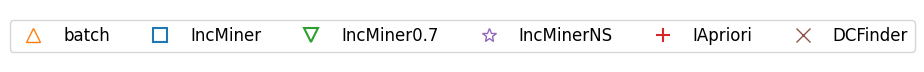

In [98]:
# Create legend elements, skipping "IncMiner1.0"
legend_elements = [
    plt.Line2D([0], [0], color=colorMap[label], marker=markerMap[label], 
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
               linestyle='', label=label)
    for label in colorMap.keys() if label != "IncMiner1.0"
]

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust width and height for a wide flat layout

# Remove axes
ax.axis('off')

# Add the legend
ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=True,
    fontsize=12,
    ncol=len(legend_elements),  # Arrange all legend entries in a single row
)

# Adjust layout
plt.tight_layout()

# Save or display the legend-only plot
plt.savefig("plots/legend.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [99]:
ylabel_time = "Running time (s)"

In [100]:
def post_process(_df):
    # 1. Compute scale factor of 'new support' over 'old support'
    _df['supportScale'] = _df['new support'] / _df['old support']

    # 2. Compute absolute difference of 'new confidence' over 'old confidence'
    _df['confDiff'] = _df['new confidence'] - _df['old confidence']
    
    # 3. Assign new label name
    _df['label'] = _df['Baseline'] + _df['beta'].fillna('').astype(str)
    
    # 4. Convert Mining time scale
    _df['time'] = _df['Mining time'] / 1000

    return _df

In [101]:
def compute_speedup(df, baseline_label, target_labels, metric="time"):
    """
    Compute the maximal and average speedup for target labels compared to a baseline label,
    replacing zero values with 1 to avoid division errors.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing timing data.
        baseline_label (str): The label of the baseline group (e.g., 'batch').
        target_labels (list): A list of labels for the groups to compare against the baseline.
    
    Returns:
        dict: A dictionary with the speedup results for each target label.
    """
    # Group by the "label" column
    groups = df.groupby('label')
    
    # Extract baseline times
    if baseline_label not in groups.groups:
        raise ValueError(f"Baseline label '{baseline_label}' not found in data.")
    
    # times_baseline = groups.get_group(baseline_label)['time'].replace(0, 1).values  # Replace 0 with 1
    times_baseline = groups.get_group(baseline_label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

    
    # Initialize results dictionary
    speedup_results = {}
    
    # Compute speedup for each target label
    for label in target_labels:
        if label not in groups.groups:
            print(f"Warning: Target label '{label}' not found in data. Skipping.")
            continue
        
        # times_target = groups.get_group(label)['time'].replace(0, 1).values  # Replace 0 with 1
        times_target = groups.get_group(label)[metric].apply(lambda x: max(x, 1)).values  # Replace values < 1 with 1

        
        # Ensure the baseline and target have the same number of entries
        if len(times_baseline) != len(times_target):
            raise ValueError(f"Mismatch in number of entries for baseline '{baseline_label}' and target '{label}'.")
        
        # Calculate speedup
        speedups = times_baseline / times_target
        
        # Store results
        speedup_results[label] = {
            "max_speedup": speedups.max(),
            "avg_speedup": speedups.mean()
        }
    
    return speedup_results

# Exp-3 : vary K

In [102]:
tab = 'vary K'
df = dfs[tab]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,1,0.7,20,143727,...,NaN,24.901459,23.870969,1.030467,0,0.000023,1.0,-0.3,IncMiner0.7,143.727
1,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,2,0.7,20,146360,...,NaN,24.481539,23.331662,1.149854,0,0.000023,1.0,-0.3,IncMiner0.7,146.360
2,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.7,20,150679,...,NaN,24.033647,22.805283,1.228341,0,0.000023,1.0,-0.3,IncMiner0.7,150.679
3,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,4,0.7,20,153995,...,NaN,23.823119,22.489033,1.334064,0,0.000023,1.0,-0.3,IncMiner0.7,153.995
4,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,5,0.7,20,165975,...,NaN,23.589503,22.265990,1.323490,0,0.000023,1.0,-0.3,IncMiner0.7,165.975


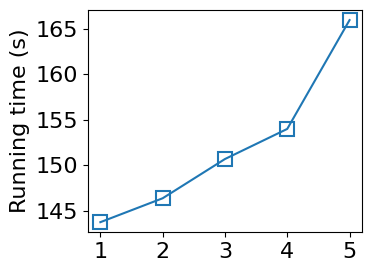

In [103]:
select = df['Baseline'] == 'IncMiner'
X = df[select]["K"]
Y = df[select]["time"] 

plt.figure()
label = "IncMiner"
plt.plot(X, Y, marker='s',
                        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)  
plt.ylabel('Running time (s)')  # Label for the y-axis

xtick_labels = [str(x) for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('K')  # Label for the x-axis
    plt.title('K vs Mining Time')  # Title of the plot
    
outfile = "plots/exp3_hospital_k_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    

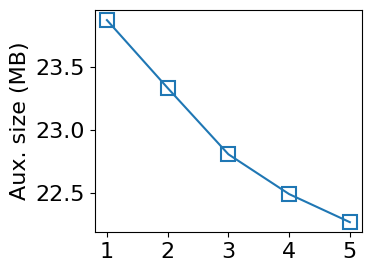

In [104]:
X = df[select]["K"]
Y = df[select]["auxiliary size"] 
# Y = df[select]["sample number"] 

# Plot the data
plt.figure()
plt.plot(X, Y, marker='s',                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Aux. size (MB)')  # Label for the y-axis


xtick_labels = [str(x) for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.title(tab)
    plt.xlabel('K')  # Label for the x-axis

outfile = "plots/exp3_hospital_k_storage.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight') 

# Show the plot
plt.show()

**Comments**:

Why at K=1, aux.size is the same as K=3. 
We also expect a positive correlation between K and auxiliary data size.

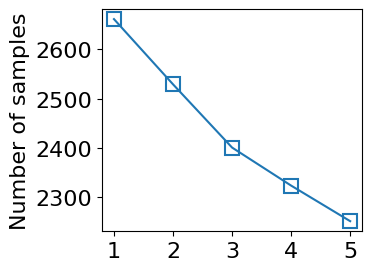

In [105]:
X = df[select]["K"]
Y = df[select]["sample number"] 

# Plot the data
plt.figure()
plt.plot(X, Y, marker="s",                 markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)  # You can change the color and line style
plt.ylabel('Number of samples')  # Label for the y-axis

xtick_labels = [str(x) for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.title(tab)
    plt.xlabel('K')  # Label for the x-axis

outfile = "plots/exp3_hospital_k_samples.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight') 

# Show the plot
plt.show()

## Vary beta

In [106]:
df = dfs["vary beta"]
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,use neighbor confs,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,supportScale,confDiff,label,time
0,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.6,20,130973,...,NaN,23.928524,22.805283,1.123219,0,0.000023,1.0,-0.3,IncMiner0.6,130.973
1,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.7,20,153884,...,NaN,23.745255,22.805283,0.939950,0,0.000023,1.0,-0.3,IncMiner0.7,153.884
2,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.8,20,168663,...,NaN,23.948734,22.805283,1.143429,0,0.000023,1.0,-0.3,IncMiner0.8,168.663
3,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,0.9,20,191316,...,NaN,23.667345,22.805283,0.862040,0,0.000023,1.0,-0.3,IncMiner0.9,191.316
4,inc_rds.hospital,0.000001,0.9,0.000001,0.6,IncMiner,3,1.0,20,278490,...,NaN,23.464969,22.805283,0.659663,0,0.000023,1.0,-0.3,IncMiner1.0,278.490


0     85
1     89
2     91
3     96
4    100
Name: recall rate, dtype: int64


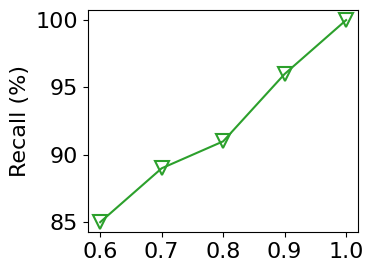

In [107]:

# Assuming 'Sample number' is a column in df and 'Mining time' is another column
X = df["beta"]
Y = (df["recall rate"] * 100).round().astype(int)
print(Y)

# Plot the data
label = "IncMiner0.7"
plt.plot(X, Y, marker=markerMap[label], color=colorMap[label],                
         markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Recall (%)')  # Label for the y-axis

xtick_labels = [f"{x:.1f}" for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('beta')  # Label for the x-axis
    
outfile = "plots/exp3_hospital_beta_recall.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')     

# Show the plot
plt.show()

In [108]:
np.mean((df["recall rate"]-X)[0:4])

np.float64(0.15026595744680823)

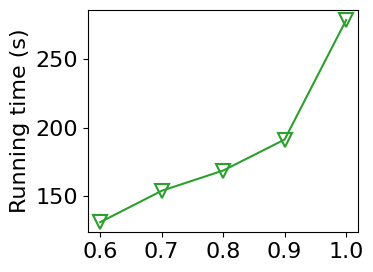

In [109]:
X = df["beta"]
Y = df["time"]

# Plot the data
label = "IncMiner0.7"
plt.plot(X, Y, marker=markerMap[label], color=colorMap[label],
                        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Running time (s)')  # Label for the y-axis

xtick_labels = [f"{x:.1f}" for x in X]
plt.xticks(X, xtick_labels)

if VERBOSE:
    plt.xlabel('beta')  # Label for the x-axis
    
outfile = "plots/exp3_hospital_beta_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()

## Comments

Now the mining time is too fast. May use a larger dataset.

# Exp-2

## Vary |D|

In [110]:
tab = 'vary |D| size'

df = dfs[tab]
# df = pd.read_excel('results-vary-d-large-1-5.xlsx')
df = post_process(df)
df['time-per-rule'] = df["time"] / df['decision tree REE number']
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,|D| size,Mining time,...,decision tree REE number,decision tree size,total size,not decision tree ree,frequest itemSets time(s),supportScale,confDiff,label,time,time-per-rule
0,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.2,88865.000000,...,4357.0,17.855036,68.824582,395.0,NaN,0.1,-0.1,IncMiner0.7,88.865000,0.020396
1,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.4,153066.000000,...,5943.0,24.667562,113.636271,426.0,NaN,0.1,-0.1,IncMiner0.7,153.066000,0.025756
2,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.6,203954.000000,...,6798.0,28.762400,154.105046,453.0,NaN,0.1,-0.1,IncMiner0.7,203.954000,0.030002
3,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,0.8,222347.000000,...,6715.0,28.881948,189.585740,467.0,NaN,0.1,-0.1,IncMiner0.7,222.347000,0.033112
4,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,1.0,236622.000000,...,6226.0,26.951264,222.412769,542.0,NaN,0.1,-0.1,IncMiner0.7,236.622000,0.038005
5,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.2,175882.000000,...,11683.0,47.742509,98.536230,351.0,NaN,0.1,-0.1,IncMiner1.0,175.882000,0.015055
6,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.4,280402.000000,...,14632.0,60.393650,149.301526,433.0,NaN,0.1,-0.1,IncMiner1.0,280.402000,0.019164
7,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.6,381101.000000,...,16166.0,68.219078,193.378830,422.0,NaN,0.1,-0.1,IncMiner1.0,381.101000,0.023574
8,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,0.8,467858.000000,...,18321.0,77.747424,238.251814,429.0,NaN,0.1,-0.1,IncMiner1.0,467.858000,0.025537
9,dblp,0.00001,0.8,0.000001,0.7,IncMiner,3,1.0,1.0,533144.000000,...,18032.0,77.409133,272.671961,488.0,NaN,0.1,-0.1,IncMiner1.0,533.144000,0.029567


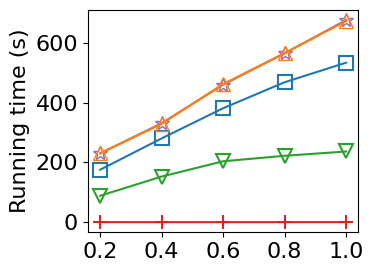

{'IncMiner1.0': {'max_speedup': np.float64(1.311771528638519),
  'avg_speedup': np.float64(1.23297196521557)},
 'IncMiner0.7': {'max_speedup': np.float64(2.840838975243215),
  'avg_speedup': np.float64(2.4782166582241616)}}

In [111]:
# Group by the "label" column
groups = df.groupby('label')

plt.figure()
for label, group in groups:
    plt.plot(group['|D| size'], group['time'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
if VERBOSE:
    plt.legend()
    plt.xlabel('|D|')  # Label for the x-axis
plt.ylabel(ylabel_time)

xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_dblp_d_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()

compute_speedup(df, "batch", ["IncMiner1.0", "IncMiner0.7"])

# compute_speedup(df, "IncMiner1.0", ["IncMiner0.7"])

IApriori
IncMiner0.7
IncMiner1.0
IncMinerNS
batch


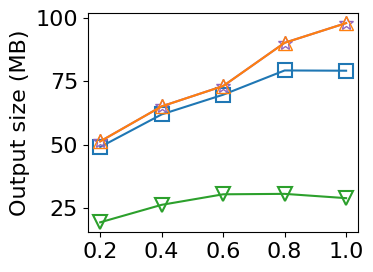

In [112]:
plt.figure()
for label, group in groups:
    print (label)
    # print (group['output size'])
    plt.plot(group['|D| size'], group['output size'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Output size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_dblp_d_output.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      
    
# Show the plot
plt.show()

Questions:
    1. Why IncMiner has smaller output size than batchMiner?
    2. Why IncMienr0.7 has less than 50% output size of BatchMiner? By design it should has at least 70%.

IApriori
IncMiner0.7
IncMiner1.0
IncMinerNS


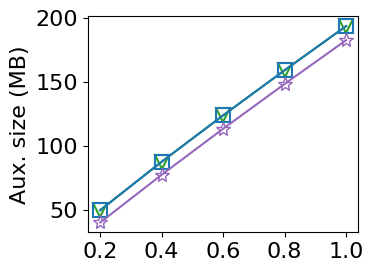

{'IncMinerNS': {'max_speedup': np.float64(1.2410874119474946),
  'avg_speedup': np.float64(1.1197075378596328)}}

In [113]:
plt.figure()
for label, group in groups:
    if label == 'batch':
        continue
        
    print (label)
    # print (group['auxiliary size'])
    plt.plot(group['|D| size'], group['auxiliary size'], label=label, color=colorMap[label], 
             marker=markerMap[label],
             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Aux. size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_dblp_d_aux.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      

# Show the plot
plt.show()

compute_speedup(df, "IncMiner1.0", ["IncMinerNS"], metric='auxiliary size')

**Comments**: 

IncMinerNS is expcted to have less auxiliary data 
as it stores no samples.

## Large dataset

In [114]:
# df = pd.read_excel('results-vary-d-large-1-5.xlsx')
df = pd.read_excel('results-1-9-vary-d-large-fix-support.xlsx')
df = post_process(df)
df['time-per-rule'] = df["time"] / df['decision tree REE number']
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,|D| size,Mining time,...,minimal size,not decision tree REE number,not decision tree size,decision tree REE number,decision tree size,supportScale,confDiff,label,time,time-per-rule
0,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,0.7,0.2,33015,...,0.065593,9,0.065593,280,0.936212,0.1,-0.2,IncMiner0.7,33.015,0.117911
1,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,0.7,0.4,219048,...,0.156281,30,0.156281,1291,4.486186,0.1,-0.2,IncMiner0.7,219.048,0.169673
2,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,0.7,0.6,301617,...,0.137830,25,0.137830,1227,4.324537,0.1,-0.2,IncMiner0.7,301.617,0.245817
3,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,0.7,0.8,1360371,...,0.232451,43,0.232451,6302,24.108067,0.1,-0.2,IncMiner0.7,1360.371,0.215863
4,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,0.7,1.0,2205525,...,0.284304,60,0.284304,8280,32.145810,0.1,-0.2,IncMiner0.7,2205.525,0.266368
5,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,1.0,0.2,32332,...,0.065593,9,0.065593,286,0.954466,0.1,-0.2,IncMiner1.0,32.332,0.113049
6,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,1.0,0.4,212761,...,0.156281,30,0.156281,1296,4.507509,0.1,-0.2,IncMiner1.0,212.761,0.164167
7,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,1.0,0.6,298890,...,0.137830,25,0.137830,1213,4.292473,0.1,-0.2,IncMiner1.0,298.890,0.246406
8,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,1.0,0.8,1371688,...,0.232451,43,0.232451,6260,23.951830,0.1,-0.2,IncMiner1.0,1371.688,0.219119
9,park_song,0.00001,0.8,0.000001,0.6,IncMiner,3,1.0,1.0,2306444,...,0.297874,64,0.297874,8399,32.553892,0.1,-0.2,IncMiner1.0,2306.444,0.274609


IncMiner0.7
0      33.015
1     219.048
2     301.617
3    1360.371
4    2205.525
Name: time, dtype: float64
IncMiner1.0
5      32.332
6     212.761
7     298.890
8    1371.688
9    2306.444
Name: time, dtype: float64
IncMinerNS
10      72.679
11     342.381
12     548.756
13    1796.723
14    2905.176
Name: time, dtype: float64
batch
15      76.193
16     344.822
17     549.630
18    1808.935
19    2895.741
Name: time, dtype: float64


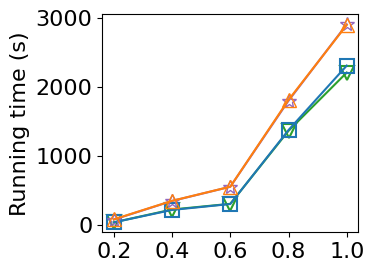

{'IncMiner1.0': {'max_speedup': np.float64(2.356581714709885),
  'avg_speedup': np.float64(1.6780905402479422)},
 'IncMiner0.7': {'max_speedup': np.float64(2.3078297743449947),
  'avg_speedup': np.float64(1.6693954976036955)}}

In [115]:
# Group by the "label" column
groups = df.groupby('label')

plt.figure()
for label, group in groups:
    print(label)
    print(group['time'])
    plt.plot(group['|D| size'], group['time'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
if VERBOSE:
    plt.legend()
    plt.xlabel('|D|')  # Label for the x-axis
plt.ylabel(ylabel_time)

xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_parksong_d_time.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')  

# Show the plot
plt.show()

compute_speedup(df, "batch", ["IncMiner1.0", "IncMiner0.7"])

# compute_speedup(df, "IncMiner1.0", ["IncMiner0.7"])

IncMiner0.7
IncMiner1.0
IncMinerNS
batch


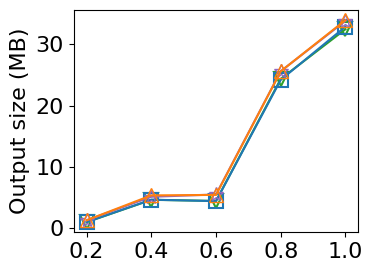

In [116]:
plt.figure()
for label, group in groups:
    print (label)
    plt.plot(group['|D| size'], group['output size'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Output size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_parksong_d_output.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      
    
# Show the plot
plt.show()

IncMiner0.7
IncMiner1.0
IncMinerNS
batch


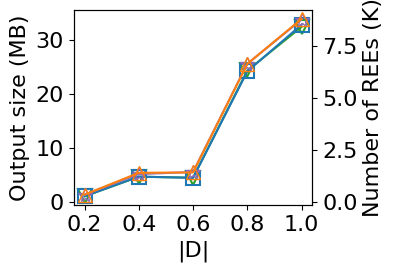

In [117]:
# Create the figure and the main axis
fig, ax_left = plt.subplots()

# Plot the primary y-axis data
for label, group in groups:
    print(label)
    ax_left.plot(
        group['|D| size'], group['output size'], label=label,
        color=colorMap[label], marker=markerMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
    )

# Configure the left y-axis
ax_left.set_ylabel('Output size (MB)')
ax_left.set_xlabel('|D|')
ax_left.tick_params(axis='y')

# Add a secondary y-axis for "REE number"
ax_right = ax_left.twinx()  # Create a twin y-axis sharing the same x-axis

# Plot the secondary y-axis data
for label, group in groups:
    ax_right.plot(
        group['|D| size'], group['minimal REE number']/1000, alpha=0)

# Configure the right y-axis
ax_right.set_ylabel('Number of REEs (K)')
ax_right.tick_params(axis='y')

# Set x-ticks
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
ax_left.set_xticks(group['|D| size'])
ax_left.set_xticklabels(xtick_labels)

# Add title and layout adjustments
if VERBOSE:
    ax_left.set_title(tab)

plt.tight_layout()
outfile = "plots/exp2_parksong_d_output.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Show the plot
plt.show()

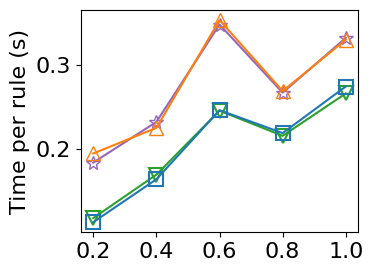

In [118]:
groups = df.groupby('label')

plt.figure()
for label, group in groups:
    plt.plot(group['|D| size'], group['time-per-rule'], label=label, color=colorMap[label], marker=markerMap[label],
                markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Time per rule (s)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_d_time-per-rule.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      
    
# Show the plot
plt.show()

IncMiner0.7
231.297160148621 1067.80246162415
IncMiner1.0
231.297160148621 1067.80246162415
IncMinerNS
231.273565292358 1064.1509437561


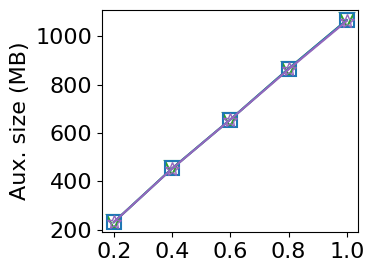

{'IncMinerNS': {'max_speedup': np.float64(1.0034313909032126),
  'avg_speedup': np.float64(1.0019060913857287)}}

In [119]:
plt.figure()
for label, group in groups:
    if label == 'batch':
        continue
        
    print (label)
    Y = group['auxiliary size']
    print (Y.min(), Y.max())
    plt.plot(group['|D| size'], group['auxiliary size'], label=label, color=colorMap[label], 
             marker=markerMap[label],
             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            ) 

# Plot the data
plt.ylabel('Aux. size (MB)')  # Label for the y-axis
if VERBOSE:
    plt.xlabel('|D|')  # Label for the x-axis
    plt.title(tab)
    plt.legend()
    
xtick_labels = [f"{d:.1f}" for d in group['|D| size']]
plt.xticks(group['|D| size'], xtick_labels)

outfile = "plots/exp2_parksong_d_aux.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')      

# Show the plot
plt.show()

compute_speedup(df, "IncMiner1.0", ["IncMinerNS"], metric='auxiliary size')

## Vary n

In [120]:
dfs_varyn = pd.read_excel('results-vary-n.xlsx', sheet_name=None)

# Print the names of the sheets
print(dfs_varyn.keys())

dict_keys(['vary n'])


In [121]:
key = 'vary n'
df = dfs_varyn[key]
df_iapriori = dfs_iapriori['vary n']


# 1. Update the 'Baseline' column in df_iapriori to 'iapriori'
df_iapriori['Baseline'] = 'IApriori'

# 2. Rename column 'gen rule time(s)' in df_iapriori to 'Mining time'
df_iapriori.rename(columns={'gen rule time(s)': 'Mining time'}, inplace=True)


# 3. Fill 'old support' and 'old confidence' in df_iapriori
#    with the values from dfs[key] where 'Baseline' == 'batch'
batch_rows = df[df['Baseline'] == 'batch']
df_iapriori['old support'] = batch_rows['old support'].values
df_iapriori['old confidence'] = batch_rows['old confidence'].values

# Concatenate the updated df_iapriori with the main DataFrame
df = pd.concat([df, df_iapriori], ignore_index=True)

In [122]:
df = post_process(df)
df

,数据集名称,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances 数量,Mining time,...,REE 数量,Num.of prune REEs,taskId,dataset name,worker instances,frequest itemSets time(s),supportScale,confDiff,label,time
0,inspection,0.00001,0.8,0.000001,0.7,IncMiner,3,NaN,4.0,7.962940e+05,...,2615.0,0.0,1000773.0,NaN,NaN,NaN,0.1,-0.1,IncMiner,796.294000
1,inspection,NaN,NaN,NaN,NaN,IncMiner,3,NaN,8.0,4.253770e+05,...,2615.0,0.0,1000777.0,NaN,NaN,NaN,NaN,NaN,IncMiner,425.377000
2,inspection,NaN,NaN,NaN,NaN,IncMiner,3,NaN,12.0,3.088340e+05,...,2615.0,0.0,1000781.0,NaN,NaN,NaN,NaN,NaN,IncMiner,308.834000
3,inspection,NaN,NaN,NaN,NaN,IncMiner,3,NaN,16.0,2.841410e+05,...,2615.0,0.0,1000785.0,NaN,NaN,NaN,NaN,NaN,IncMiner,284.141000
4,inspection,NaN,NaN,NaN,NaN,IncMiner,3,NaN,20.0,1.920150e+05,...,2615.0,0.0,1000791.0,NaN,NaN,NaN,NaN,NaN,IncMiner,192.015000
5,inspection,0.00001,0.8,0.000001,0.7,IncMiner,3,0.7,4.0,7.029960e+05,...,2407.0,0.0,1000774.0,NaN,NaN,NaN,0.1,-0.1,IncMiner0.7,702.996000
6,inspection,NaN,NaN,NaN,NaN,IncMiner,3,0.7,8.0,3.776770e+05,...,2407.0,0.0,1000778.0,NaN,NaN,NaN,NaN,NaN,IncMiner0.7,377.677000
7,inspection,NaN,NaN,NaN,NaN,IncMiner,3,0.7,12.0,2.754030e+05,...,2407.0,0.0,1000782.0,NaN,NaN,NaN,NaN,NaN,IncMiner0.7,275.403000
8,inspection,NaN,NaN,NaN,NaN,IncMiner,3,0.7,16.0,2.479900e+05,...,2407.0,0.0,1000786.0,NaN,NaN,NaN,NaN,NaN,IncMiner0.7,247.990000
9,inspection,NaN,NaN,NaN,NaN,IncMiner,3,0.7,20.0,1.671290e+05,...,2407.0,0.0,1000792.0,NaN,NaN,NaN,NaN,NaN,IncMiner0.7,167.129000


IApriori 1.9812754973907858
IncMiner 4.1470405957867875
IncMiner0.7 4.20630770243345
IncMinerNS 4.233196045478574
batch 4.2345567170880365


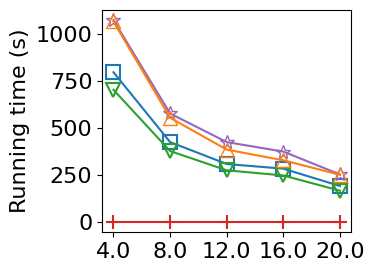

{'IncMiner': {'max_speedup': np.float64(1.3383863246489363),
  'avg_speedup': np.float64(1.2713631518397008)},
 'IncMiner0.7': {'max_speedup': np.float64(1.5160100484213281),
  'avg_speedup': np.float64(1.4428585800512381)}}

In [123]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    X = group["worker instances 数量"]
    Y = group['time']
    print(label, max(Y) / min(Y))
    plt.plot(range(len(X)), Y, label=label, marker=markerMap[label],color=colorMap[label],
                            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [v for v in X]
plt.xticks(range(len(X)), xtick_labels)


if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp2_vary_n.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

compute_speedup(df, "batch", ["IncMiner", "IncMiner0.7"])


# Exp-1

## support increase

In [124]:
tab = 'support increase'
df = dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),index,supportScale,confDiff,label,time
0,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMiner,3,0.7,20,0.000000e+00,...,21.552022,0.914148,0.0,0.000023,NaN,NaN,10.0,0.0,IncMiner0.7,0.000000
1,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMiner,3,0.7,20,0.000000e+00,...,21.552022,0.333122,0.0,0.000023,NaN,NaN,100.0,0.0,IncMiner0.7,0.000000
2,inc_rds.adult,0.000001,0.75,0.00100,0.75,IncMiner,3,0.7,20,0.000000e+00,...,21.552022,0.313022,0.0,0.000023,NaN,NaN,1000.0,0.0,IncMiner0.7,0.000000
3,inc_rds.adult,0.000001,0.75,0.01000,0.75,IncMiner,3,0.7,20,0.000000e+00,...,21.552022,0.251007,0.0,0.000023,NaN,NaN,10000.0,0.0,IncMiner0.7,0.000000
4,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMiner,3,NaN,20,0.000000e+00,...,21.552022,0.914148,0.0,0.000023,NaN,NaN,10.0,0.0,IncMiner,0.000000
5,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMiner,3,NaN,20,0.000000e+00,...,21.552022,0.333122,0.0,0.000023,NaN,NaN,100.0,0.0,IncMiner,0.000000
6,inc_rds.adult,0.000001,0.75,0.00100,0.75,IncMiner,3,NaN,20,0.000000e+00,...,21.552022,0.313022,0.0,0.000023,NaN,NaN,1000.0,0.0,IncMiner,0.000000
7,inc_rds.adult,0.000001,0.75,0.01000,0.75,IncMiner,3,NaN,20,0.000000e+00,...,21.552022,0.251007,0.0,0.000023,NaN,NaN,10000.0,0.0,IncMiner,0.000000
8,inc_rds.adult,0.000001,0.75,0.00001,0.75,IncMinerNS,3,NaN,20,0.000000e+00,...,2.454939,0.914148,0.0,0.000023,NaN,NaN,10.0,0.0,IncMinerNS,0.000000
9,inc_rds.adult,0.000001,0.75,0.00010,0.75,IncMinerNS,3,NaN,20,0.000000e+00,...,2.454939,0.333122,0.0,0.000023,NaN,NaN,100.0,0.0,IncMinerNS,0.000000


DCFinder
IApriori
IncMiner
IncMiner0.7
IncMinerNS
batch


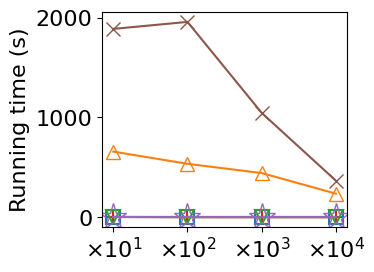

{'IncMiner': {'max_speedup': np.float64(658.082),
  'avg_speedup': np.float64(468.51325)},
 'IncMiner0.7': {'max_speedup': np.float64(658.082),
  'avg_speedup': np.float64(468.51325)}}

In [125]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    print (label)
    X = group['supportScale']
    # print (group['time'])
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
                            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
                markersize=markerStyleMap[label].get('markersize', 10)) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
plt.xticks(range(len(X)), xtick_labels)


if VERBOSE:
    plt.xlabel('supportScale')  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_increase_supp.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## support decrease

In [126]:
tab = 'support decrease'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),supportScale,confDiff,label,time
0,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMiner,3,0.7,20,2005.000000,...,29.787149,29.787104,0.000023,0.0,0.000023,NaN,0.1000,0.0,IncMiner0.7,2.005000
1,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMiner,3,0.7,20,18758.000000,...,30.076203,29.967672,0.108508,0.0,0.000023,NaN,0.0100,0.0,IncMiner0.7,18.758000
2,inc_rds.inspection,0.01,0.75,0.000010,0.75,IncMiner,3,0.7,20,167490.000000,...,30.154875,29.890682,0.264170,0.0,0.000023,NaN,0.0010,0.0,IncMiner0.7,167.490000
3,inc_rds.inspection,0.01,0.75,0.000001,0.75,IncMiner,3,0.7,20,335200.000000,...,30.017729,29.133776,0.883930,0.0,0.000023,NaN,0.0001,0.0,IncMiner0.7,335.200000
4,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMiner,3,NaN,20,1891.000000,...,29.787149,29.787104,0.000023,0.0,0.000023,NaN,0.1000,0.0,IncMiner,1.891000
5,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMiner,3,NaN,20,18833.000000,...,30.076203,29.967672,0.108508,0.0,0.000023,NaN,0.0100,0.0,IncMiner,18.833000
6,inc_rds.inspection,0.01,0.75,0.000010,0.75,IncMiner,3,NaN,20,168100.000000,...,30.154875,29.890682,0.264170,0.0,0.000023,NaN,0.0010,0.0,IncMiner,168.100000
7,inc_rds.inspection,0.01,0.75,0.000001,0.75,IncMiner,3,NaN,20,336663.000000,...,30.017729,29.133776,0.883930,0.0,0.000023,NaN,0.0001,0.0,IncMiner,336.663000
8,inc_rds.inspection,0.01,0.75,0.001000,0.75,IncMinerNS,3,NaN,20,2048.000000,...,29.736165,29.736119,0.000023,0.0,0.000023,NaN,0.1000,0.0,IncMinerNS,2.048000
9,inc_rds.inspection,0.01,0.75,0.000100,0.75,IncMinerNS,3,NaN,20,18863.000000,...,30.025219,29.916688,0.108508,0.0,0.000023,NaN,0.0100,0.0,IncMinerNS,18.863000


IApriori
IncMiner
IncMiner0.7
IncMinerNS
batch


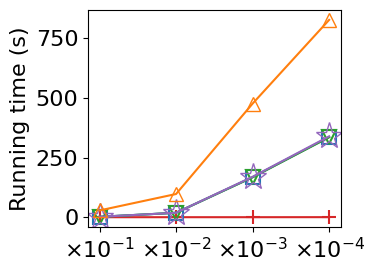

{'IncMiner': {'max_speedup': np.float64(15.167107350608145),
  'avg_speedup': np.float64(6.409235855055611)},
 'IncMiner0.7': {'max_speedup': np.float64(14.304738154613467),
  'avg_speedup': np.float64(6.204081508943939)}}

In [127]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()  # Adjust the figure size if needed

for label, group in groups:
    print(label)
    X = group['supportScale']
    plt.plot(range(len(X)), group['time'], label=label, marker=markerMap[label],color=colorMap[label],
             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
             markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
             markersize=markerStyleMap[label].get('markersize', 10)
            ) 

# Add plot labels and legend
plt.ylabel('Running time (s)')  # Label for y-axis
# plt.xscale("log")

xtick_labels = [fr"$\times 10^{{{int(np.log10(value))}}}$" for value in X]
plt.xticks(range(len(X)), xtick_labels)


if VERBOSE:
    plt.xlabel('supportScale')  # Label for x-axis
    plt.title(tab)
    # plt.legend()
    
outfile = "plots/exp1_inspection_decrease_supp.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

**Comments**:

Expect a consistent gap between batch and the rest.
At small \Delta \sigma, the gap is close to zero.

## confidence increase

In [128]:
tab = 'confidence increase'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.7,0.000001,0.75,IncMiner,3,0.7,20,9.353000e+03,...,35.316135,34.466459,0.849653,0.0,0.000023,NaN,1.0,0.05,IncMiner0.7,9.353000
1,inc_rds.inspection,0.000001,0.7,0.000001,0.80,IncMiner,3,0.7,20,2.456800e+04,...,36.150887,35.159388,0.991477,0.0,0.000023,NaN,1.0,0.10,IncMiner0.7,24.568000
2,inc_rds.inspection,0.000001,0.7,0.000001,0.85,IncMiner,3,0.7,20,5.207300e+04,...,37.157378,36.108680,1.048676,0.0,0.000023,NaN,1.0,0.15,IncMiner0.7,52.073000
3,inc_rds.inspection,0.000001,0.7,0.000001,0.90,IncMiner,3,0.7,20,1.044000e+05,...,38.104409,36.914202,1.190185,0.0,0.000023,NaN,1.0,0.20,IncMiner0.7,104.400000
4,inc_rds.inspection,0.000001,0.7,0.000001,0.95,IncMiner,3,0.7,20,1.902220e+05,...,39.439556,38.200987,1.238546,0.0,0.000023,NaN,1.0,0.25,IncMiner0.7,190.222000
5,inc_rds.inspection,0.000001,0.7,0.000001,0.75,IncMiner,3,NaN,20,8.999000e+03,...,35.316135,34.466459,0.849653,0.0,0.000023,NaN,1.0,0.05,IncMiner,8.999000
6,inc_rds.inspection,0.000001,0.7,0.000001,0.80,IncMiner,3,NaN,20,2.460100e+04,...,36.150887,35.159388,0.991477,0.0,0.000023,NaN,1.0,0.10,IncMiner,24.601000
7,inc_rds.inspection,0.000001,0.7,0.000001,0.85,IncMiner,3,NaN,20,5.207700e+04,...,37.157378,36.108680,1.048676,0.0,0.000023,NaN,1.0,0.15,IncMiner,52.077000
8,inc_rds.inspection,0.000001,0.7,0.000001,0.90,IncMiner,3,NaN,20,1.035220e+05,...,38.104409,36.914202,1.190185,0.0,0.000023,NaN,1.0,0.20,IncMiner,103.522000
9,inc_rds.inspection,0.000001,0.7,0.000001,0.95,IncMiner,3,NaN,20,1.911030e+05,...,39.439556,38.200987,1.238546,0.0,0.000023,NaN,1.0,0.25,IncMiner,191.103000


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_94260/3748121871.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \delta$")  # Label for x-axis


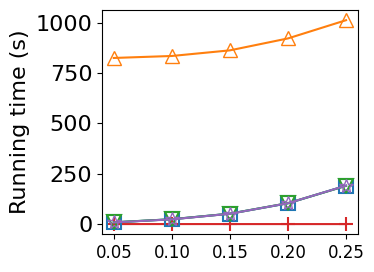

{'IncMiner': {'max_speedup': np.float64(91.69341037893099),
  'avg_speedup': np.float64(31.282392435721597)},
 'IncMiner0.7': {'max_speedup': np.float64(88.22292312626965),
  'avg_speedup': np.float64(30.58759311992673)}}

In [129]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    plt.plot(group['confDiff'], group['time'], label=label, marker=markerMap[label], color=colorMap[label],
            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),)

# Add plot labels and legend
plt.ylabel(ylabel_time)

if VERBOSE:
    plt.xlabel("$\Delta \delta$")  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
        
plt.tick_params(axis='x', labelsize=12)  

outfile = "plots/exp1_inspection_increase_conf.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

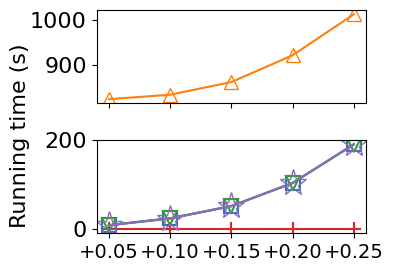

{'IncMiner': {'max_speedup': np.float64(91.69341037893099),
  'avg_speedup': np.float64(31.282392435721597)},
 'IncMiner0.7': {'max_speedup': np.float64(88.22292312626965),
  'avg_speedup': np.float64(30.58759311992673)}}

In [130]:
# Group by the "label" column
groups = df.groupby('label')

# Create a figure with two subplots (vertically stacked)
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)

# Plot for "batch" in the top box
if 'batch' in groups.groups:
    batch_group = groups.get_group('batch')
    Y = batch_group['time']
    ax_top.plot(
        range(len(Y)), batch_group['time'], label='batch',
        marker=markerMap['batch'], color=colorMap['batch'],
        markerfacecolor=markerStyleMap['batch'].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap['batch'].get('markeredgewidth', 1.0),
    )

# Plot for other labels in the bottom box
for label, group in groups:
    if label != 'batch':  # Skip "batch" for the bottom plot
        Y = group['time']
        ax_bottom.plot(
            range(len(Y)), group['time'], label=label,
            marker=markerMap[label], color=colorMap[label],
            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
            markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            markersize=markerStyleMap[label].get('markersize', 10)
        )


X = group['confDiff']
xtick_labels = [f"+{v:.2f}" for v in X]
plt.xticks(range(len(X)), xtick_labels, fontsize=14)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_inspection_increase_conf.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## confidence decrease

In [131]:
tab = 'confidence decrease'
df =dfs[tab]
df = post_process(df)
df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.95,0.000001,0.90,IncMiner,3,0.7,20,70536.000000,...,40.997581,39.702646,1.294912,0.0,0.000023,NaN,1.0,-0.05,IncMiner0.7,70.536000
1,inc_rds.inspection,0.000001,0.95,0.000001,0.85,IncMiner,3,0.7,20,92183.000000,...,41.010135,39.702646,1.307466,0.0,0.000023,NaN,1.0,-0.10,IncMiner0.7,92.183000
2,inc_rds.inspection,0.000001,0.95,0.000001,0.80,IncMiner,3,0.7,20,98205.000000,...,40.992496,39.702646,1.289826,0.0,0.000023,NaN,1.0,-0.15,IncMiner0.7,98.205000
3,inc_rds.inspection,0.000001,0.95,0.000001,0.75,IncMiner,3,0.7,20,103631.000000,...,40.945346,39.702646,1.242677,0.0,0.000023,NaN,1.0,-0.20,IncMiner0.7,103.631000
4,inc_rds.inspection,0.000001,0.95,0.000001,0.70,IncMiner,3,0.7,20,113008.000000,...,40.941546,39.702646,1.238877,0.0,0.000023,NaN,1.0,-0.25,IncMiner0.7,113.008000
5,inc_rds.inspection,0.000001,0.95,0.000001,0.90,IncMiner,3,NaN,20,183982.000000,...,40.801917,39.702646,1.099248,0.0,0.000023,NaN,1.0,-0.05,IncMiner,183.982000
6,inc_rds.inspection,0.000001,0.95,0.000001,0.85,IncMiner,3,NaN,20,185829.000000,...,40.646017,39.702646,0.943348,0.0,0.000023,NaN,1.0,-0.10,IncMiner,185.829000
7,inc_rds.inspection,0.000001,0.95,0.000001,0.80,IncMiner,3,NaN,20,182575.000000,...,40.576019,39.702646,0.873350,0.0,0.000023,NaN,1.0,-0.15,IncMiner,182.575000
8,inc_rds.inspection,0.000001,0.95,0.000001,0.75,IncMiner,3,NaN,20,190047.000000,...,40.467529,39.702646,0.764860,0.0,0.000023,NaN,1.0,-0.20,IncMiner,190.047000
9,inc_rds.inspection,0.000001,0.95,0.000001,0.70,IncMiner,3,NaN,20,202153.000000,...,40.503951,39.702646,0.801282,0.0,0.000023,NaN,1.0,-0.25,IncMiner,202.153000


<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mv/j_58gf917nd0c2nczfjyc3900000gn/T/ipykernel_94260/661808557.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \delta$")  # Label for x-axis


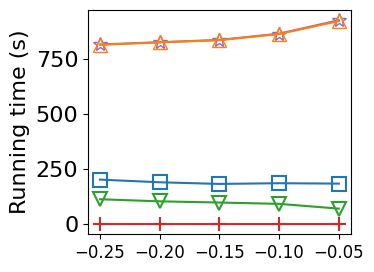

{'IncMiner': {'max_speedup': np.float64(5.007163744279332), 'avg_speedup': np.float64(4.516225009409854)}, 'IncMiner0.7': {'max_speedup': np.float64(13.060394692072132), 'avg_speedup': np.float64(9.213562017632572)}}
{'IncMiner0.7': {'max_speedup': np.float64(2.6083418396279914), 'avg_speedup': np.float64(2.021210676549599)}}


In [132]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    plt.plot(group['confDiff'], group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis


if VERBOSE:
    plt.xlabel("$\Delta \delta$")  # Label for x-axis
    plt.title(tab)
    plt.legend()
    
plt.tick_params(axis='x', labelsize=12)  

outfile = "plots/exp1_inspection_decrease_conf.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
# Display the plot
plt.show()

# Compute speedup
print(compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7']))

print(compute_speedup(df, 'IncMiner', ['IncMiner0.7']))

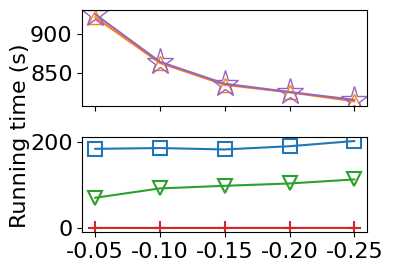

{'IncMiner': {'max_speedup': np.float64(5.007163744279332),
  'avg_speedup': np.float64(4.516225009409854)},
 'IncMiner0.7': {'max_speedup': np.float64(13.060394692072132),
  'avg_speedup': np.float64(9.213562017632572)}}

In [133]:
# Group by the "label" column
groups = df.groupby('label')

# Create a figure with two subplots (vertically stacked)
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)


top_labels = ['batch', 'IncMinerNS']
bottom_labels = ['IncMiner', 'IncMiner0.7', 'IApriori']

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


X = group['confDiff']
xtick_labels = [f"{v:.2f}" for v in X]
plt.xticks(range(len(X)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_inspection_decrease_conf.pdf"

plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## s+c+

In [134]:
tab = 'supp inc | conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMiner,3,0.7,20,5752.000000,...,38.744583,38.442465,0.302095,0.0,0.000023,NaN,10.0,0.05,IncMiner0.7,5.752000
1,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMiner,3,0.7,20,4580.000000,...,39.190511,39.017492,0.172996,0.0,0.000023,NaN,100.0,0.10,IncMiner0.7,4.580000
2,inc_rds.inspection,0.000001,0.7,0.00100,0.85,IncMiner,3,0.7,20,1214.000000,...,39.060520,39.060474,0.000023,0.0,0.000023,NaN,1000.0,0.15,IncMiner0.7,1.214000
3,inc_rds.inspection,0.000001,0.7,0.01000,0.90,IncMiner,3,0.7,20,774.000000,...,39.041077,39.041031,0.000023,0.0,0.000023,NaN,10000.0,0.20,IncMiner0.7,0.774000
4,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMiner,3,NaN,20,5336.000000,...,38.744583,38.442465,0.302095,0.0,0.000023,NaN,10.0,0.05,IncMiner,5.336000
5,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMiner,3,NaN,20,4592.000000,...,39.190511,39.017492,0.172996,0.0,0.000023,NaN,100.0,0.10,IncMiner,4.592000
6,inc_rds.inspection,0.000001,0.7,0.00100,0.85,IncMiner,3,NaN,20,1292.000000,...,39.060520,39.060474,0.000023,0.0,0.000023,NaN,1000.0,0.15,IncMiner,1.292000
7,inc_rds.inspection,0.000001,0.7,0.01000,0.90,IncMiner,3,NaN,20,914.000000,...,39.041077,39.041031,0.000023,0.0,0.000023,NaN,10000.0,0.20,IncMiner,0.914000
8,inc_rds.inspection,0.000001,0.7,0.00001,0.75,IncMinerNS,3,NaN,20,5383.000000,...,30.859060,30.556942,0.302095,0.0,0.000023,NaN,10.0,0.05,IncMinerNS,5.383000
9,inc_rds.inspection,0.000001,0.7,0.00010,0.80,IncMinerNS,3,NaN,20,4126.000000,...,31.365912,31.192894,0.172996,0.0,0.000023,NaN,100.0,0.10,IncMinerNS,4.126000


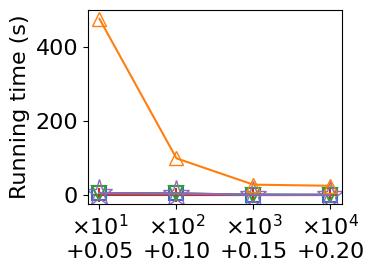

{'IncMiner': {'max_speedup': np.float64(89.44415292353823),
  'avg_speedup': np.float64(39.5998430051049)},
 'IncMiner0.7': {'max_speedup': np.float64(82.97531293463143),
  'avg_speedup': np.float64(38.34870530285781)}}

In [135]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
             markersize=markerStyleMap[label].get('markersize', 10)
            )
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s+c+_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## S+C-

In [136]:
tab = 'supp inc | conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),index,supportScale,confDiff,label,time
0,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMiner,3,0.7,20,4.112900e+04,...,32.487323,0.944035,0.0,0.000023,NaN,NaN,10.0,-0.05,IncMiner0.7,41.129000
1,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMiner,3,0.7,20,6.265800e+04,...,32.487323,0.795058,0.0,0.000023,NaN,NaN,100.0,-0.10,IncMiner0.7,62.658000
2,inc_rds.adult,0.000001,0.95,0.00100,0.80,IncMiner,3,0.7,20,8.308900e+04,...,32.487323,0.800678,0.0,0.000023,NaN,NaN,1000.0,-0.15,IncMiner0.7,83.089000
3,inc_rds.adult,0.000001,0.95,0.01000,0.75,IncMiner,3,0.7,20,9.521300e+04,...,32.487323,0.998651,0.0,0.000023,NaN,NaN,10000.0,-0.20,IncMiner0.7,95.213000
4,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMiner,3,NaN,20,9.339800e+04,...,32.487323,0.638452,0.0,0.000023,NaN,NaN,10.0,-0.05,IncMiner,93.398000
5,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMiner,3,NaN,20,1.135760e+05,...,32.487323,0.470932,0.0,0.000023,NaN,NaN,100.0,-0.10,IncMiner,113.576000
6,inc_rds.adult,0.000001,0.95,0.00100,0.80,IncMiner,3,NaN,20,1.357300e+05,...,32.487323,0.419765,0.0,0.000023,NaN,NaN,1000.0,-0.15,IncMiner,135.730000
7,inc_rds.adult,0.000001,0.95,0.01000,0.75,IncMiner,3,NaN,20,1.542480e+05,...,32.487323,0.463850,0.0,0.000023,NaN,NaN,10000.0,-0.20,IncMiner,154.248000
8,inc_rds.adult,0.000001,0.95,0.00001,0.90,IncMinerNS,3,NaN,20,9.593340e+05,...,2.454939,1.280627,19370.0,75.095021,NaN,NaN,10.0,-0.05,IncMinerNS,959.334000
9,inc_rds.adult,0.000001,0.95,0.00010,0.85,IncMinerNS,3,NaN,20,6.763010e+05,...,2.638958,0.220093,18463.0,71.328004,NaN,NaN,100.0,-0.10,IncMinerNS,676.301000


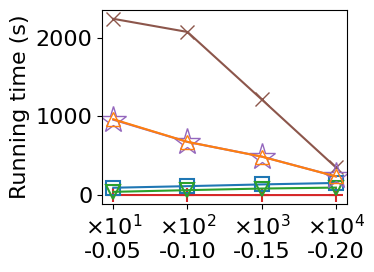

{'IncMiner': {'max_speedup': np.float64(10.331548855435877),
  'avg_speedup': np.float64(5.360047951908347)},
 'IncMiner0.7': {'max_speedup': np.float64(23.46145055800044),
  'avg_speedup': np.float64(10.663758167021285)}}

In [137]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                            markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            markersize=markerStyleMap[label].get('markersize', 10))
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s+c-_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

# compute_speedup(df, 'IncMiner', ['IncMiner0.7'])

## S-C+

In [138]:
tab = 'supp dec | conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),supportScale,confDiff,label,time
0,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMiner,3,0.7,20,2131.000000,...,29.846432,29.846386,0.000023,0.0,0.000023,NaN,0.1000,0.05,IncMiner0.7,2.131000
1,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMiner,3,0.7,20,18994.000000,...,30.724841,30.576385,0.148433,0.0,0.000023,NaN,0.0100,0.10,IncMiner0.7,18.994000
2,inc_rds.inspection,0.01,0.7,0.000010,0.85,IncMiner,3,0.7,20,176400.000000,...,35.128071,34.809259,0.318789,0.0,0.000023,NaN,0.0010,0.15,IncMiner0.7,176.400000
3,inc_rds.inspection,0.01,0.7,0.000001,0.90,IncMiner,3,0.7,20,407654.000000,...,40.154231,38.857201,1.297008,0.0,0.000023,NaN,0.0001,0.20,IncMiner0.7,407.654000
4,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMiner,3,NaN,20,2104.000000,...,29.846432,29.846386,0.000023,0.0,0.000023,NaN,0.1000,0.05,IncMiner,2.104000
5,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMiner,3,NaN,20,19184.000000,...,30.724841,30.576385,0.148433,0.0,0.000023,NaN,0.0100,0.10,IncMiner,19.184000
6,inc_rds.inspection,0.01,0.7,0.000010,0.85,IncMiner,3,NaN,20,176822.000000,...,35.128071,34.809259,0.318789,0.0,0.000023,NaN,0.0010,0.15,IncMiner,176.822000
7,inc_rds.inspection,0.01,0.7,0.000001,0.90,IncMiner,3,NaN,20,412069.000000,...,40.154231,38.857201,1.297008,0.0,0.000023,NaN,0.0001,0.20,IncMiner,412.069000
8,inc_rds.inspection,0.01,0.7,0.001000,0.75,IncMinerNS,3,NaN,20,1941.000000,...,29.738338,29.738293,0.000023,0.0,0.000023,NaN,0.1000,0.05,IncMinerNS,1.941000
9,inc_rds.inspection,0.01,0.7,0.000100,0.80,IncMinerNS,3,NaN,20,18989.000000,...,30.094937,29.946482,0.148433,0.0,0.000023,NaN,0.0100,0.10,IncMinerNS,18.989000


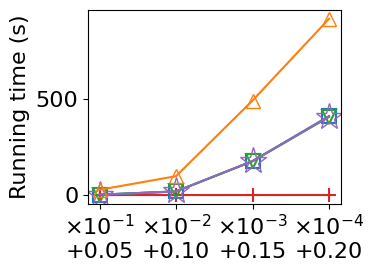

{'IncMiner': {'max_speedup': np.float64(13.224334600760457),
  'avg_speedup': np.float64(5.846392129566542)},
 'IncMiner0.7': {'max_speedup': np.float64(13.056780854059129),
  'avg_speedup': np.float64(5.825069877538627)}}

In [139]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
             markersize=markerStyleMap[label].get('markersize', 10)
            )
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:+.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s-c+_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## S-C-

In [155]:
tab = 'supp dec | conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),index,supportScale,confDiff,label,time
0,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMiner,3,0.7,20,8.518800e+04,...,22.703724,0.557168,0.0,0.000023,NaN,NaN,0.1000,-0.05,IncMiner0.7,85.188000
1,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMiner,3,0.7,20,1.132020e+05,...,23.131517,0.229047,0.0,0.000023,NaN,NaN,0.0100,-0.10,IncMiner0.7,113.202000
2,inc_rds.adult,0.01,0.95,0.000010,0.80,IncMiner,3,0.7,20,1.515240e+05,...,26.110974,1.455980,0.0,0.000023,NaN,NaN,0.0010,-0.15,IncMiner0.7,151.524000
3,inc_rds.adult,0.01,0.95,0.000001,0.75,IncMiner,3,0.7,20,1.409030e+05,...,25.160165,0.883308,0.0,0.000023,NaN,NaN,0.0001,-0.20,IncMiner0.7,140.903000
4,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMiner,3,NaN,20,9.199200e+04,...,22.703724,0.096059,0.0,0.000023,NaN,NaN,0.1000,-0.05,IncMiner,91.992000
5,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMiner,3,NaN,20,1.364690e+05,...,23.131517,0.156374,0.0,0.000023,NaN,NaN,0.0100,-0.10,IncMiner,136.469000
6,inc_rds.adult,0.01,0.95,0.000010,0.80,IncMiner,3,NaN,20,1.802560e+05,...,26.110974,0.711972,0.0,0.000023,NaN,NaN,0.0010,-0.15,IncMiner,180.256000
7,inc_rds.adult,0.01,0.95,0.000001,0.75,IncMiner,3,NaN,20,1.702470e+05,...,25.160165,0.752964,0.0,0.000023,NaN,NaN,0.0001,-0.20,IncMiner,170.247000
8,inc_rds.adult,0.01,0.95,0.001000,0.90,IncMinerNS,3,NaN,20,6.507050e+05,...,5.137802,0.118011,14805.0,57.031095,NaN,NaN,0.1000,-0.05,IncMinerNS,650.705000
9,inc_rds.adult,0.01,0.95,0.000100,0.85,IncMinerNS,3,NaN,20,6.842200e+05,...,2.638958,0.220093,18607.0,71.843302,NaN,NaN,0.0100,-0.10,IncMinerNS,684.220000


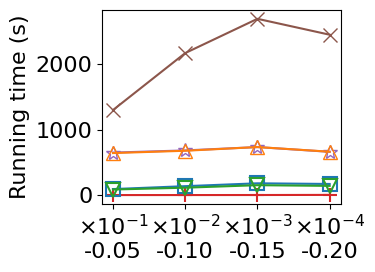

{'IncMiner': {'max_speedup': np.float64(6.995706148360727),
  'avg_speedup': np.float64(4.987962296023073)},
 'IncMiner0.7': {'max_speedup': np.float64(7.554456026670422),
  'avg_speedup': np.float64(5.779800397237365)}}

In [156]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
            )
    
xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s-c-_lambda_rate.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

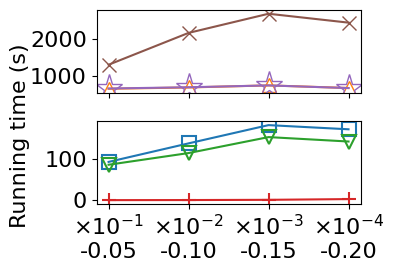

{'IncMiner': {'max_speedup': np.float64(6.995706148360727),
  'avg_speedup': np.float64(4.987962296023073)},
 'IncMiner0.7': {'max_speedup': np.float64(7.554456026670422),
  'avg_speedup': np.float64(5.779800397237365)}}

In [157]:
# Group by the "label" column
groups = df.groupby('label')

# Create a figure with two subplots (vertically stacked)
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)


top_labels = ['batch', 'IncMinerNS', 'DCFinder']
bottom_labels = ['IncMiner', 'IncMiner0.7', 'IApriori']

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


xtick_labels = [fr"$\times 10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['supportScale'], group['confDiff'])]
plt.xticks(range(len(group)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_adult_s-c-_lambda_rate.pdf"
plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

**Comments**:

Should exhibit some monotoniciy: the 3rd or 4th data point rerun?

# Change initial parameters

## S+C+

In [143]:
tab = '(old change) supp inc|conf inc'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,output size,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),supportScale,confDiff,label,time
0,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMiner,3,0.7,20,4830.000000,...,37.130666,36.768492,0.362151,0.0,0.000023,NaN,10.0,0.05,IncMiner0.7,4.830000
1,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMiner,3,0.7,20,8270.000000,...,34.527855,34.376399,0.151433,0.0,0.000023,NaN,10.0,0.05,IncMiner0.7,8.270000
2,inc_rds.inspection,0.000100,0.85,0.00100,0.90,IncMiner,3,0.7,20,2.000000,...,33.445442,33.445396,0.000023,0.0,0.000023,NaN,10.0,0.05,IncMiner0.7,0.002000
3,inc_rds.inspection,0.001000,0.90,0.01000,0.95,IncMiner,3,0.7,20,0.000000,...,31.665974,31.665928,0.000023,0.0,0.000023,NaN,10.0,0.05,IncMiner0.7,0.000000
4,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMiner,3,NaN,20,5102.000000,...,37.130666,36.768492,0.362151,0.0,0.000023,NaN,10.0,0.05,IncMiner,5.102000
5,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMiner,3,NaN,20,8402.000000,...,34.527855,34.376399,0.151433,0.0,0.000023,NaN,10.0,0.05,IncMiner,8.402000
6,inc_rds.inspection,0.000100,0.85,0.00100,0.90,IncMiner,3,NaN,20,2.000000,...,33.445442,33.445396,0.000023,0.0,0.000023,NaN,10.0,0.05,IncMiner,0.002000
7,inc_rds.inspection,0.001000,0.90,0.01000,0.95,IncMiner,3,NaN,20,0.000000,...,31.665974,31.665928,0.000023,0.0,0.000023,NaN,10.0,0.05,IncMiner,0.000000
8,inc_rds.inspection,0.000001,0.75,0.00001,0.80,IncMinerNS,3,NaN,20,5024.000000,...,31.009304,30.647130,0.362151,0.0,0.000023,NaN,10.0,0.05,IncMinerNS,5.024000
9,inc_rds.inspection,0.000010,0.80,0.00010,0.85,IncMinerNS,3,NaN,20,8389.000000,...,31.658413,31.506957,0.151433,0.0,0.000023,NaN,10.0,0.05,IncMinerNS,8.389000


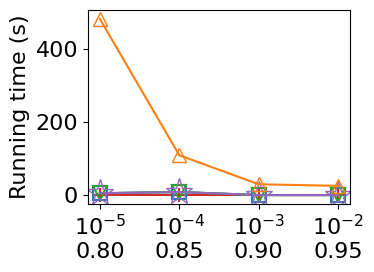

{'IncMiner': {'max_speedup': np.float64(94.35985887887102),
  'avg_speedup': np.float64(40.4952897613745)},
 'IncMiner0.7': {'max_speedup': np.float64(99.67370600414078),
  'avg_speedup': np.float64(41.87538357479578)}}

In [144]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
             markersize=markerStyleMap[label].get('markersize', 10)
            )
    
xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_inspection_s+c+_lambda_init.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

## S-C-

In [158]:
tab = '(old change) supp dec|conf dec'
df =dfs[tab]
df = post_process(df)
# df = df.dropna(subset=['supportScale'])
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,...,auxiliary size,minimal size,decision tree REE number,decision tree size,frequest itemSets time(s),index,supportScale,confDiff,label,time
0,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMiner,3,0.7,20,8.678300e+04,...,22.669427,0.557168,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner0.7,86.783000
1,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMiner,3,0.7,20,5.226700e+04,...,21.719335,0.166697,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner0.7,52.267000
2,inc_rds.adult,0.00010,0.85,0.000010,0.80,IncMiner,3,0.7,20,3.871500e+04,...,10.842013,0.173347,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner0.7,38.715000
3,inc_rds.adult,0.00001,0.80,0.000001,0.75,IncMiner,3,0.7,20,1.936000e+03,...,2.454962,0.173347,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner0.7,1.936000
4,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMiner,3,NaN,20,9.506600e+04,...,22.669427,0.096059,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner,95.066000
5,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMiner,3,NaN,20,7.721700e+04,...,21.719335,0.141020,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner,77.217000
6,inc_rds.adult,0.00010,0.85,0.000010,0.80,IncMiner,3,NaN,20,6.826700e+04,...,10.842013,0.201516,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner,68.267000
7,inc_rds.adult,0.00001,0.80,0.000001,0.75,IncMiner,3,NaN,20,6.844000e+03,...,2.454962,0.173347,0.0,0.000023,NaN,NaN,0.1,-0.05,IncMiner,6.844000
8,inc_rds.adult,0.01000,0.95,0.001000,0.90,IncMinerNS,3,NaN,20,6.546310e+05,...,5.137802,0.118011,14818.0,57.074482,NaN,NaN,0.1,-0.05,IncMinerNS,654.631000
9,inc_rds.adult,0.00100,0.90,0.000100,0.85,IncMinerNS,3,NaN,20,6.859760e+05,...,2.638958,0.220093,18611.0,71.859669,NaN,NaN,0.1,-0.05,IncMinerNS,685.976000


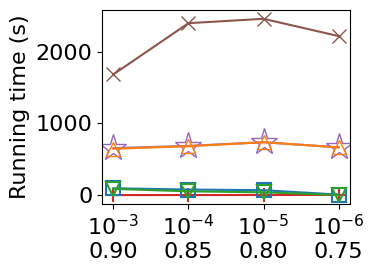

{'IncMiner': {'max_speedup': np.float64(97.18249561659847),
  'avg_speedup': np.float64(30.898762206958267)},
 'IncMiner0.7': {'max_speedup': np.float64(343.5521694214876),
  'avg_speedup': np.float64(95.76680301580429)}}

In [159]:
# Group by the "label" column
groups = df.groupby('label')

# Create a plot for each group
plt.figure()

for label, group in groups:
    
    plt.plot(range(len(group)), group['time'], label=label, marker=markerMap[label], color=colorMap[label],
                             markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
                markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
             markersize=markerStyleMap[label].get('markersize', 10)
            )
    
xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

# plt.tick_params(axis='x', labelsize=16)  
# plt.tick_params(axis='y', labelsize=14)  

# Add plot labels and legend
plt.ylabel(ylabel_time)  # Label for y-axis

if VERBOSE:
    plt.title(tab)
    plt.legend()
    
outfile = "plots/exp1_adult_s-c-_lambda_init.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')    
    
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

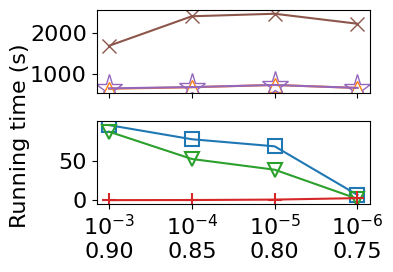

{'IncMiner': {'max_speedup': np.float64(97.18249561659847),
  'avg_speedup': np.float64(30.898762206958267)},
 'IncMiner0.7': {'max_speedup': np.float64(343.5521694214876),
  'avg_speedup': np.float64(95.76680301580429)}}

In [160]:
# Group by the "label" column
groups = df.groupby('label')

# Create a figure with two subplots (vertically stacked)
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True)


top_labels = ['batch', 'IncMinerNS', 'DCFinder']
bottom_labels = ['IncMiner', 'IncMiner0.7', 'IApriori']

# Plot for labels in the top box
for label in top_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_top.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )

# Plot for other labels in the bottom box
for label in bottom_labels:
    group = groups.get_group(label)
    Y = group['time']
    ax_bottom.plot(
        range(len(Y)), group['time'], label=label,
        marker=markerMap[label], color=colorMap[label],
        markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
        markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),
        markersize=markerStyleMap[label].get('markersize', 10)
    )


xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(group['new support'], group['new confidence'])]
plt.xticks(range(len(group)), xtick_labels)

fig.text(0.01, 0.5, ylabel_time, va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()

# Save the plot
outfile = "plots/exp1_adult_s-c-_lambda_init.pdf"

plt.savefig(outfile, bbox_inches='tight')

# Display the plot
plt.show()

# Compute speedup
compute_speedup(df, 'batch', ['IncMiner', 'IncMiner0.7'])

**Comments**:

Should exhibit some monotoniciy: the 3rd or 4th data point rerun?

# Exp-5

In [148]:
dfs_guidlines = pd.read_excel('results-guidelines-12-31.xlsx', sheet_name=None)

# Print the names of the sheets
print(dfs_guidlines.keys())

dict_keys(['Guidelines(S-C-)', 'Guidelines(S-C+)'])


In [149]:
df = dfs_guidlines['Guidelines(S-C-)']
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,recall rate,cover count,taskId,supportScale,confDiff,label,time
0,inc_rds.adult,0.10000,1.00,0.01000,1.00,IncMiner,3,NaN,20,343361,0.066667,1,1003076,0.1,0.00,IncMiner,343.361
1,inc_rds.adult,0.01000,1.00,0.01000,0.95,IncMiner,3,NaN,20,8,0.200000,3,1003077,1.0,-0.05,IncMiner,0.008
2,inc_rds.adult,0.01000,0.95,0.00100,0.95,IncMiner,3,NaN,20,296787,0.266667,4,1003078,0.1,0.00,IncMiner,296.787
3,inc_rds.adult,0.00100,0.95,0.00100,0.90,IncMiner,3,NaN,20,9234,0.400000,6,1003079,1.0,-0.05,IncMiner,9.234
4,inc_rds.adult,0.00100,0.90,0.00010,0.90,IncMiner,3,NaN,20,114803,0.400000,6,1003080,0.1,0.00,IncMiner,114.803
5,inc_rds.adult,0.00010,0.90,0.00010,0.85,IncMiner,3,NaN,20,28220,0.733333,11,1003081,1.0,-0.05,IncMiner,28.220
6,inc_rds.adult,0.00010,0.85,0.00001,0.85,IncMiner,3,NaN,20,160834,0.866667,13,1003082,0.1,0.00,IncMiner,160.834
7,inc_rds.adult,0.00001,0.85,0.00001,0.80,IncMiner,3,NaN,20,42389,1.000000,15,1003083,1.0,-0.05,IncMiner,42.389


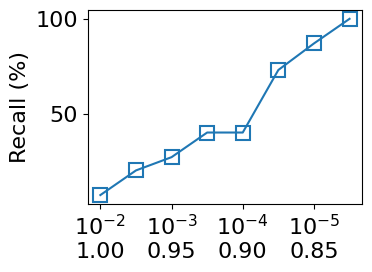

In [150]:
Y = (df["recall rate"] * 100).round().astype(int)

# Plot the data
label = "IncMiner"
plt.plot(range(1,len(Y)+1), Y, marker=markerMap[label], color=colorMap[label],                
         markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
         markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Recall (%)')  # Label for the y-axis

xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(df['new support'], df['new confidence'])]
plt.xticks(range(1,len(df)+1)[::2], xtick_labels[::2])

# plt.tick_params(axis='x', labelsize=10)  


outfile = "plots/exp5_guideline_2.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')     

# Show the plot
plt.show()

In [151]:
df["time"].cumsum()

0    343.361
1    343.369
2    640.156
3    649.390
4    764.193
5    792.413
6    953.247
7    995.636
Name: time, dtype: float64

In [152]:
df = dfs_guidlines['Guidelines(S-C+)']
df = post_process(df)
df

,dataset name,old support,old confidence,new support,new confidence,Baseline,K,beta,worker instances,Mining time,recall rate,cover count,taskId,supportScale,confDiff,label,time
0,inc_rds.adult,0.100000,0.65,0.100000,0.70,IncMiner,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.05,IncMiner,NaN
1,inc_rds.adult,0.100000,0.70,0.010000,0.70,IncMiner,3,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.00,IncMiner,NaN
2,inc_rds.adult,0.010000,0.75,0.001000,0.75,IncMiner,3,NaN,20.0,233311.0,0.866667,13.0,1003085.0,0.1,0.00,IncMiner,233.311
3,inc_rds.adult,0.001000,0.75,0.001000,0.80,IncMiner,3,NaN,20.0,47384.0,0.866667,13.0,1003086.0,1.0,0.05,IncMiner,47.384
4,inc_rds.adult,0.001000,0.80,0.000100,0.80,IncMiner,3,NaN,20.0,96090.0,0.866667,13.0,1003087.0,0.1,0.00,IncMiner,96.090
5,inc_rds.adult,0.000100,0.80,0.000100,0.85,IncMiner,3,NaN,20.0,94518.0,0.866667,13.0,1003088.0,1.0,0.05,IncMiner,94.518
6,inc_rds.adult,0.000100,0.85,0.000010,0.85,IncMiner,3,NaN,20.0,162949.0,1.000000,15.0,1003089.0,0.1,0.00,IncMiner,162.949
7,inc_rds.adult,0.000010,0.85,0.000010,0.90,IncMiner,3,NaN,20.0,136267.0,1.000000,15.0,1003090.0,1.0,0.05,IncMiner,136.267
8,inc_rds.adult,0.000010,0.90,0.000001,0.90,IncMiner,3,NaN,20.0,0.0,1.000000,15.0,1003091.0,0.1,0.00,IncMiner,0.000
9,inc_rds.adult,0.000001,0.90,0.000001,0.95,IncMiner,3,NaN,20.0,191107.0,1.000000,15.0,1003092.0,1.0,0.05,IncMiner,191.107


In [153]:
Y = (df["recall rate"] * 100).round().astype(int)

# Plot the data
label = "IncMiner"
plt.plot(range(1,len(Y)+1), Y, marker=markerMap[label], color=colorMap[label],                
         markerfacecolor=markerStyleMap[label].get('markerfacecolor', 'auto'),
         markeredgewidth=markerStyleMap[label].get('markeredgewidth', 1.0),) 
plt.ylabel('Recall (%)')  # Label for the y-axis

xtick_labels = [fr"$10^{{{int(np.log10(ss))}}}$"+"\n"+f"{cd:.2f}" for ss, cd in zip(df['new support'], df['new confidence'])]
# plt.xticks(range(1,len(df)+1), xtick_labels)
plt.xticks(range(1,len(df)+1)[::2], xtick_labels[::2])

# plt.tick_params(axis='x', labelsize=10)  


outfile = "plots/exp5_guideline_1.pdf"
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')     

# Show the plot
plt.show()

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
df["time"].cumsum()

In [ ]:
df = pd.read_csv("guidelines-rules-12-31-with-support-confidence.txt")

In [ ]:
df

In [ ]:
sorted_values = df['support'].sort_values()
cdf = sorted_values.rank(method='first', pct=True)

# Plot the CDF
plt.plot(sorted_values, cdf, marker='s')
plt.xscale("log")
plt.xlabel("support")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Support")
plt.show()

In [ ]:
df['support'].min()

In [ ]:
sorted_values = df['confidence'].sort_values()
cdf = sorted_values.rank(method='first', pct=True)

# Plot the CDF
plt.plot(sorted_values, cdf, marker='s')
plt.xlabel("confidence")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Confidence")
plt.show()

In [ ]:
df['confidence'].min()